In [1]:
import radarsimpy

print("`RadarSimPy` used in this example is version: " + str(radarsimpy.__version__))

`RadarSimPy` used in this example is version: 12.6.1


# Imaging Radar

## Introduction

High-Resolution Imaging Multiple Input, Multiple Output (MIMO) radar is an advanced radar technology that combines multiple antennas on both the transmitter and receiver sides to achieve high-resolution imaging of targets in various applications, including surveillance, reconnaissance, and remote sensing. Unlike traditional single-antenna radar systems, MIMO radar utilizes the spatial diversity of its antenna array to enhance its imaging capabilities. Here's a brief introduction to the key features and advantages of high-resolution imaging MIMO radar:

1. **Multiple Antennas:** High-resolution imaging MIMO radar deploys multiple antennas, often in an array configuration, at both the transmitter and receiver. This array enables the radar to transmit and receive multiple signals simultaneously.

2. **Spatial Diversity:** The use of multiple antennas allows MIMO radar to exploit the spatial diversity of the received signals. By analyzing the phase and amplitude differences among the received signals, MIMO radar can distinguish between closely spaced targets and generate high-resolution images.

3. **Improved Range and Angle Resolution:** MIMO radar significantly enhances the radar's range and angle resolution compared to traditional radar systems. This means it can accurately detect and locate multiple targets in close proximity.

4. **Increased Sensitivity:** With its ability to process multiple signals coherently, MIMO radar is more sensitive to weak or distant targets, improving its detection capabilities.

5. **Reduced Ambiguities:** MIMO radar minimizes ambiguities in target location, which can be a limitation in traditional radar systems, especially when dealing with closely spaced or overlapping targets.

6. **Adaptive Beamforming:** MIMO radar can adaptively steer its beams to focus on specific areas of interest. This adaptability allows it to track and image moving targets effectively.

7. **Applications:** High-resolution imaging MIMO radar finds applications in various fields, including military surveillance, autonomous vehicles, weather monitoring, and environmental sensing. It can be used for target identification, tracking, and even mapping of terrain and objects.

8. **Challenges:** Implementing MIMO radar systems can be complex and computationally intensive, requiring advanced signal processing algorithms. Additionally, calibration and synchronization of multiple antennas can be challenging.

In summary, high-resolution imaging MIMO radar is a cutting-edge technology that leverages multiple antennas on both the transmitter and receiver sides to achieve superior target detection and imaging capabilities. Its ability to provide high-resolution images and reduce ambiguities makes it a valuable tool in a wide range of applications where precise target information is critical.

This illustration serves as a prime example of employing ray tracing to simulate the response of a MIMO imaging radar when exposed to a pre-defined 3D scene. This simulation harnesses the robust capabilities of the [`RadarSimPy`](https://radarsimx.com/radarsimx/radarsimpy/) framework. Additionally, it provides a fundamental demonstration of the radar signal processing techniques used to generate an image of the scene.

## Setup a MIMO FMCW Radar

Firstly, import the required modules from `radarsimpy`. `numpy` will also be needed in this example.


In [2]:
import numpy as np
from radarsimpy import Radar, Transmitter, Receiver

### MIMO Array Configuration

We configure a MIMO array with 2 transmitter channels and 64 receiver channels. The synthesized array is a 1 x 128 uniform linear array. The array layout is shown below.

> Note: The modulation is not considered here. Assume the 2 transmitters are orthogonal.


In [3]:
wavelength = 3e8 / 60.5e9
N_tx = 64
N_rx = 128

tx_channels = []
for idx in range(0, int(N_tx / 2)):
    tx_channels.append(
        dict(
            location=(
                0,
                -N_rx / 2 * wavelength / 4,
                wavelength * idx - (N_tx / 2 - 1) * wavelength / 2,
            ),
        )
    )
for idx in range(0, int(N_tx / 2)):
    tx_channels.append(
        dict(
            location=(
                0,
                wavelength * N_rx / 4 - N_rx / 2 * wavelength / 4,
                wavelength * idx - (N_tx / 2 - 1) * wavelength / 2,
            ),
        )
    )

rx_channels = []
for idx in range(0, int(N_rx / 2)):
    rx_channels.append(
        dict(
            location=(
                0,
                wavelength / 2 * idx - (N_rx / 2 - 1) * wavelength / 4,
                -(N_tx / 2) * wavelength / 2,
            ),
        )
    )
for idx in range(0, int(N_rx / 2)):
    rx_channels.append(
        dict(
            location=(
                0,
                wavelength / 2 * idx - (N_rx / 2 - 1) * wavelength / 4,
                wavelength * (N_tx / 2) - (N_tx / 2) * wavelength / 2,
            ),
        )
    )

Create the radar model by using `RadarSimPy` framework.


In [4]:
tx = Transmitter(
    f=[61e9, 60e9], t=[0, 16e-6], tx_power=15, prp=40e-6, pulses=1, channels=tx_channels
)

rx = Receiver(
    fs=20e6,
    noise_figure=8,
    rf_gain=20,
    load_resistor=500,
    baseband_gain=30,
    channels=rx_channels,
)

radar = Radar(transmitter=tx, receiver=rx)

_Plot the array layout_


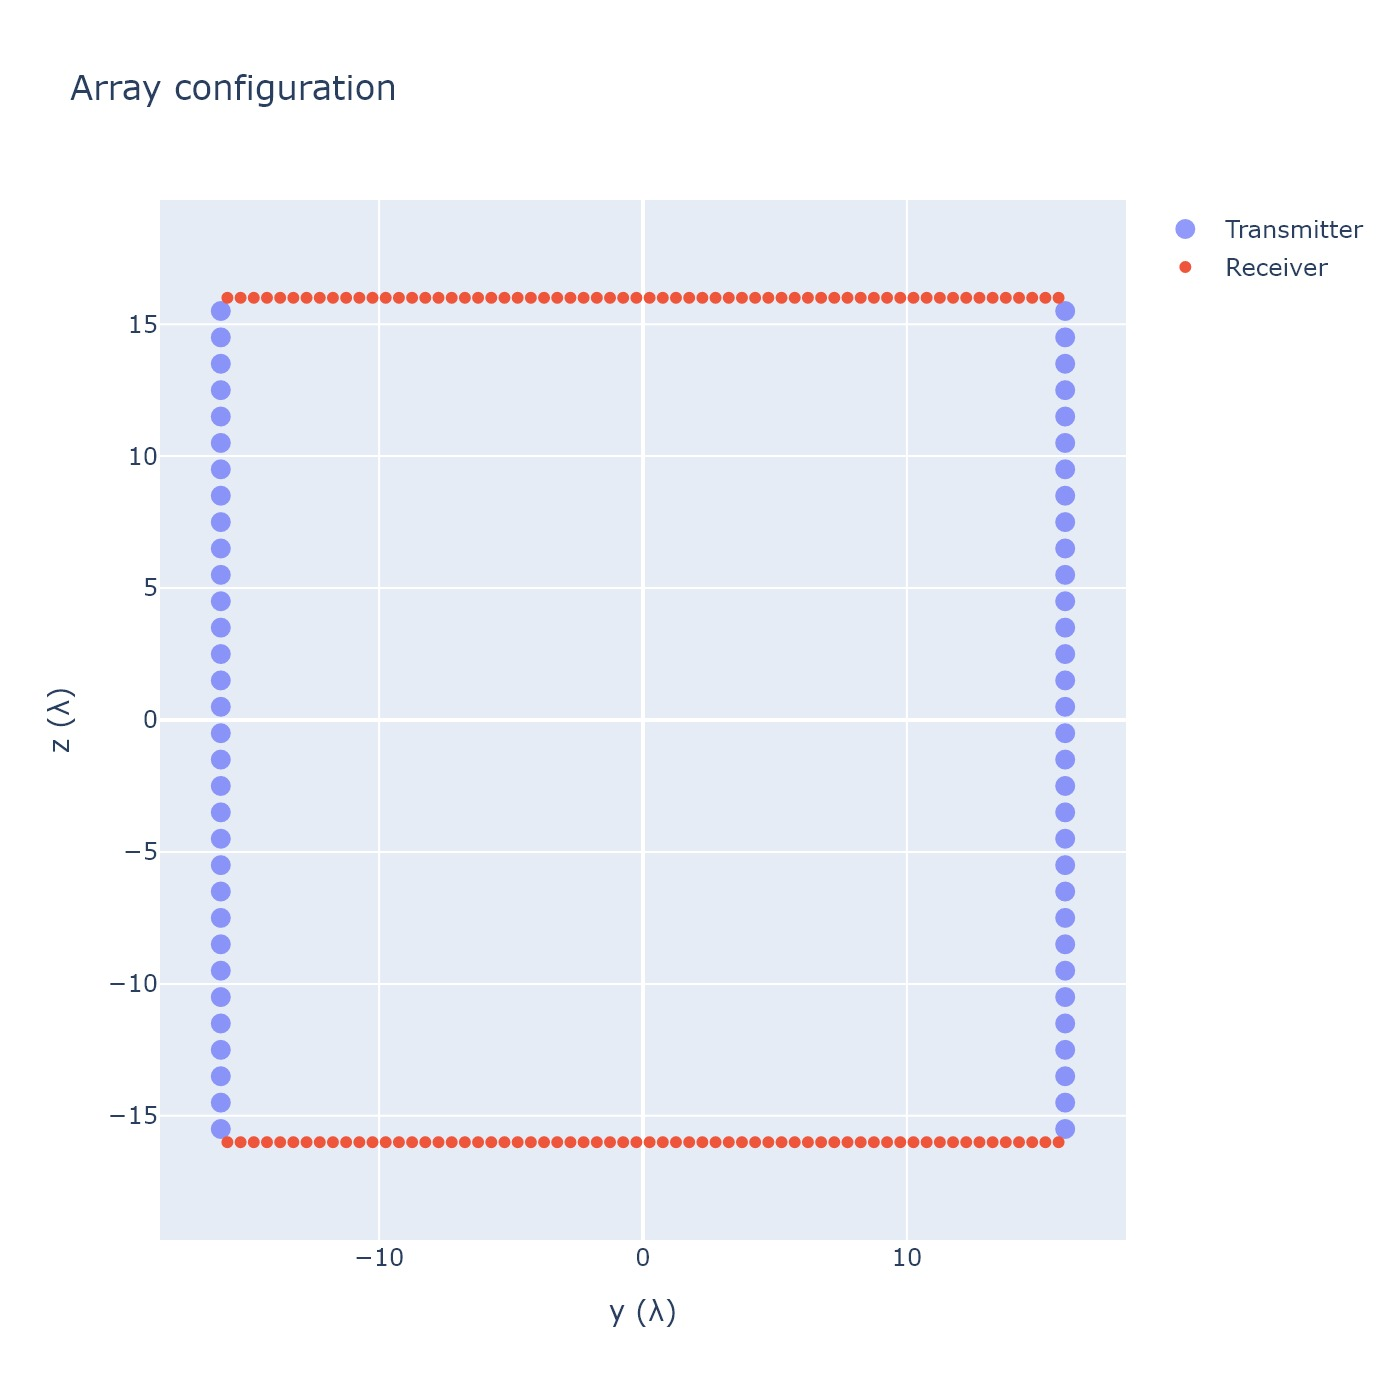

In [5]:
import plotly.graph_objs as go
from IPython.display import Image

fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 1]
        / wavelength,
        y=radar.radar_prop["transmitter"].txchannel_prop["locations"][:, 2]
        / wavelength,
        mode="markers",
        name="Transmitter",
        opacity=0.7,
        marker=dict(size=10),
    )
)

fig.add_trace(
    go.Scatter(
        x=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 1] / wavelength,
        y=radar.radar_prop["receiver"].rxchannel_prop["locations"][:, 2] / wavelength,
        mode="markers",
        opacity=1,
        name="Receiver",
    )
)

fig.update_layout(
    title="Array configuration",
    height=700,
    xaxis=dict(title="y (λ)"),
    yaxis=dict(title="z (λ)", scaleanchor="x", scaleratio=1),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Targets

The target models are with `.stl`.


In [6]:
target_1 = {
    "model": "../models/half_ring.stl",
    "unit": "m",
    "location": (20, 0, 0),
    "speed": (0, 0, 0),
    "rotation": (0, 0, 0),
}

ball_1 = {
    "model": "../models/ball_1m.stl",
    "unit": "m",
    "location": (20, -1, -1),
    "speed": (0, 0, 0),
    "rotation": (0, 0, 0),
}

ball_2 = {
    "model": "../models/ball_1m.stl",
    "unit": "m",
    "location": (20, 1, -1),
    "speed": (0, 0, 0),
    "rotation": (0, 0, 0),
}

targets = [target_1, ball_1, ball_2]

_Plot the targets in the scene_


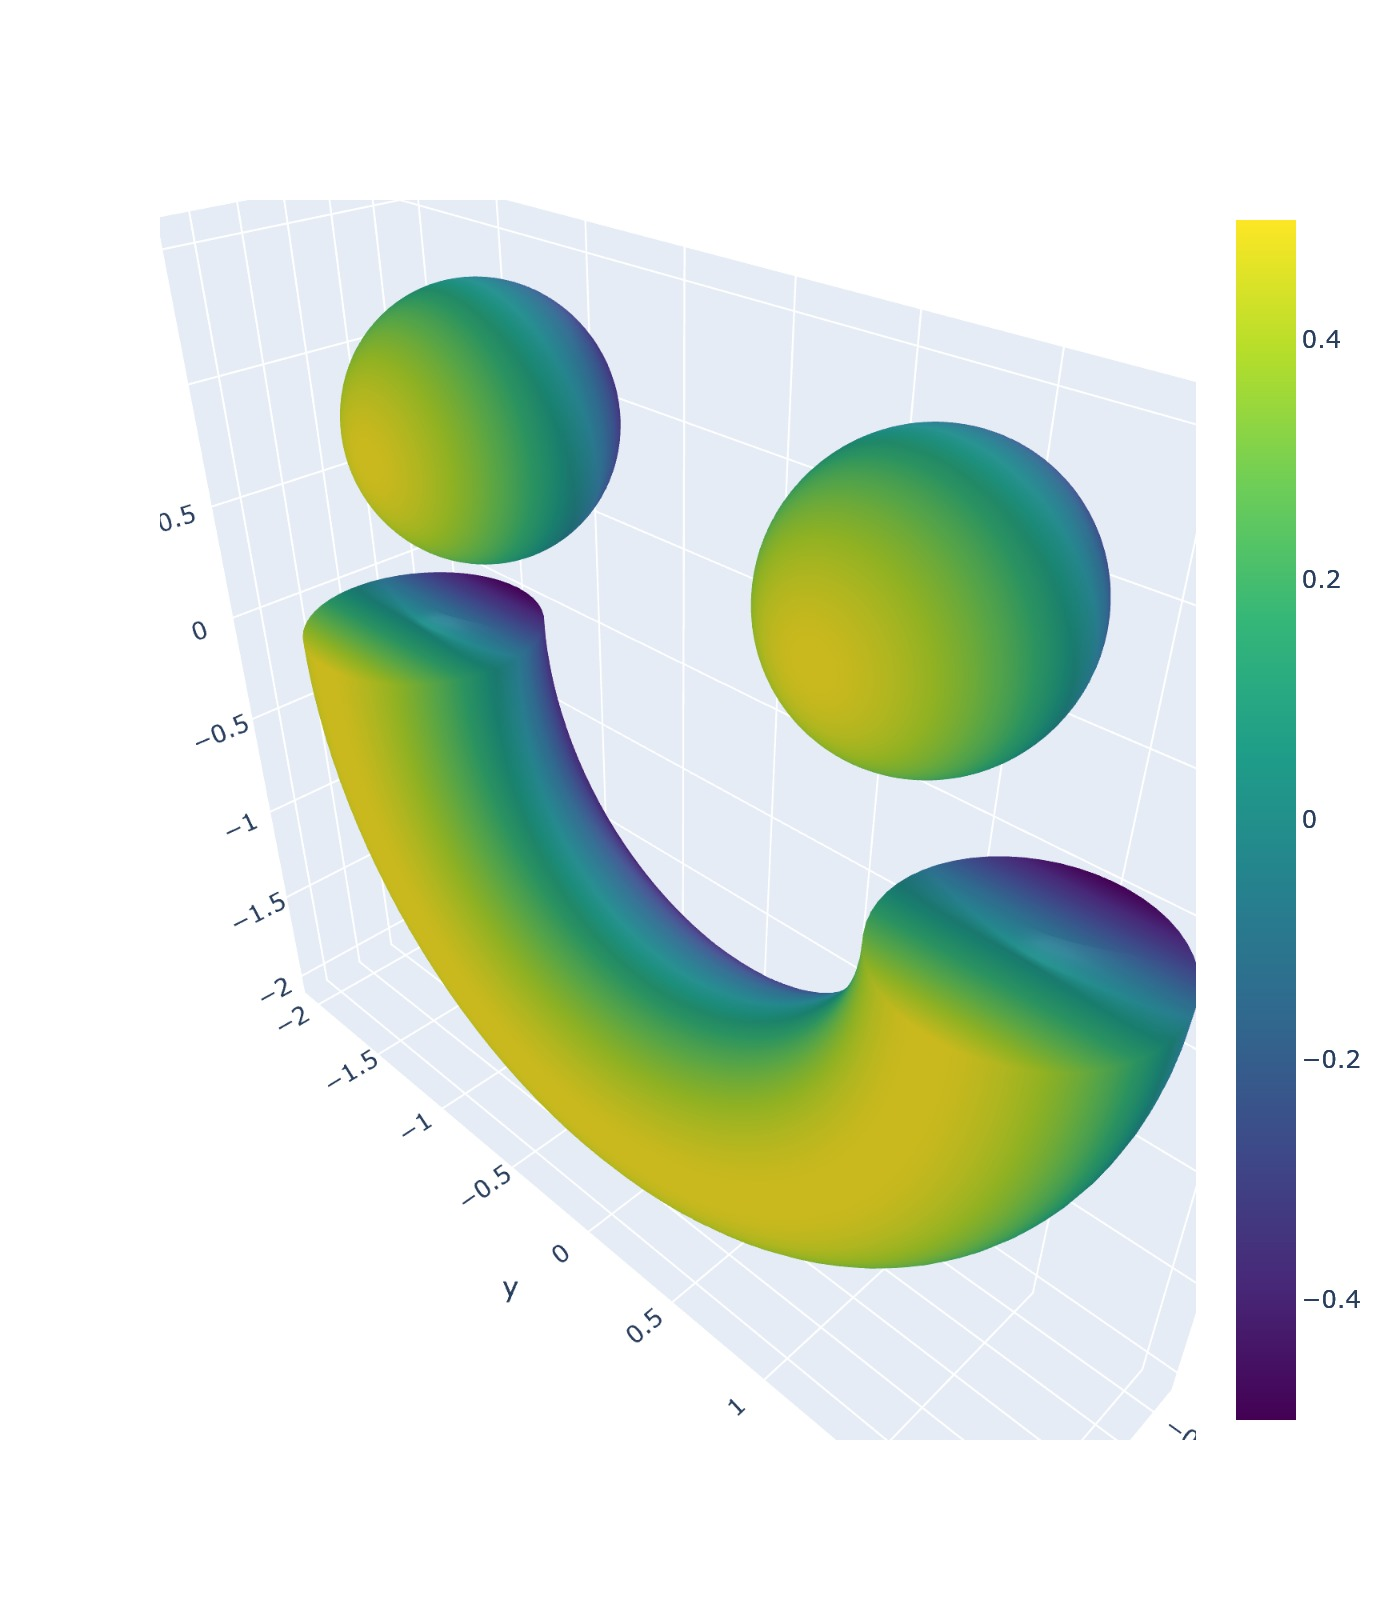

In [7]:
import pymeshlab

fig = go.Figure()

ms = pymeshlab.MeshSet()
ms.load_new_mesh(target_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1],
        z=-v_matrix[:, 2],
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 0],
        colorscale="Viridis",
    )
)

ms = pymeshlab.MeshSet()
ms.load_new_mesh(ball_1["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1] - 1,
        z=-v_matrix[:, 2] + 1,
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 0],
        colorscale="Viridis",
    )
)

ms = pymeshlab.MeshSet()
ms.load_new_mesh(ball_2["model"])
t_mesh = ms.current_mesh()
v_matrix = np.array(t_mesh.vertex_matrix())
f_matrix = np.array(t_mesh.face_matrix())
fig.add_trace(
    go.Mesh3d(
        x=v_matrix[:, 0],
        y=v_matrix[:, 1] + 1,
        z=-v_matrix[:, 2] + 1,
        i=f_matrix[:, 0],
        j=f_matrix[:, 1],
        k=f_matrix[:, 2],
        intensity=v_matrix[:, 0],
        colorscale="Viridis",
    )
)
fig["layout"]["scene"]["aspectmode"] = "data"
fig["layout"]["height"] = 800

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

## Radar Scene Simulation

Use the `simulator.sim_radar` module to simulate the baseband samples from the defined radar system and targets.

The output baseband data is a dict including the timestamp and baseband. Both of them are 3-D matrix:

`[channels, pulses, ADC samples]`


In [ ]:
from radarsimpy.simulator import sim_radar
import time

tic = time.time()
data = sim_radar(radar, targets, density=0.3)

baseband = data["baseband"] + data["noise"]
toc = time.time()

print("Exec time:", toc - tic, "s")

## Radar Signal Processing

### Range Processing and Thresholding


In [ ]:
from scipy import signal
import radarsimpy.processing as proc

range_window = signal.windows.chebwin(radar.sample_prop["samples_per_pulse"], at=80)
range_profile = proc.range_fft(baseband, rwin=range_window)

range_profile_avg = np.mean(np.abs(range_profile[:, :, :]), axis=0)
cfar = proc.cfar_os_1d(
    range_profile_avg[0, :],
    guard=0,
    trailing=10,
    k=14,
    pfa=1e-4,
    offset=1.1,
    detector="linear",
)

_Plot averaged range profile and threshold_


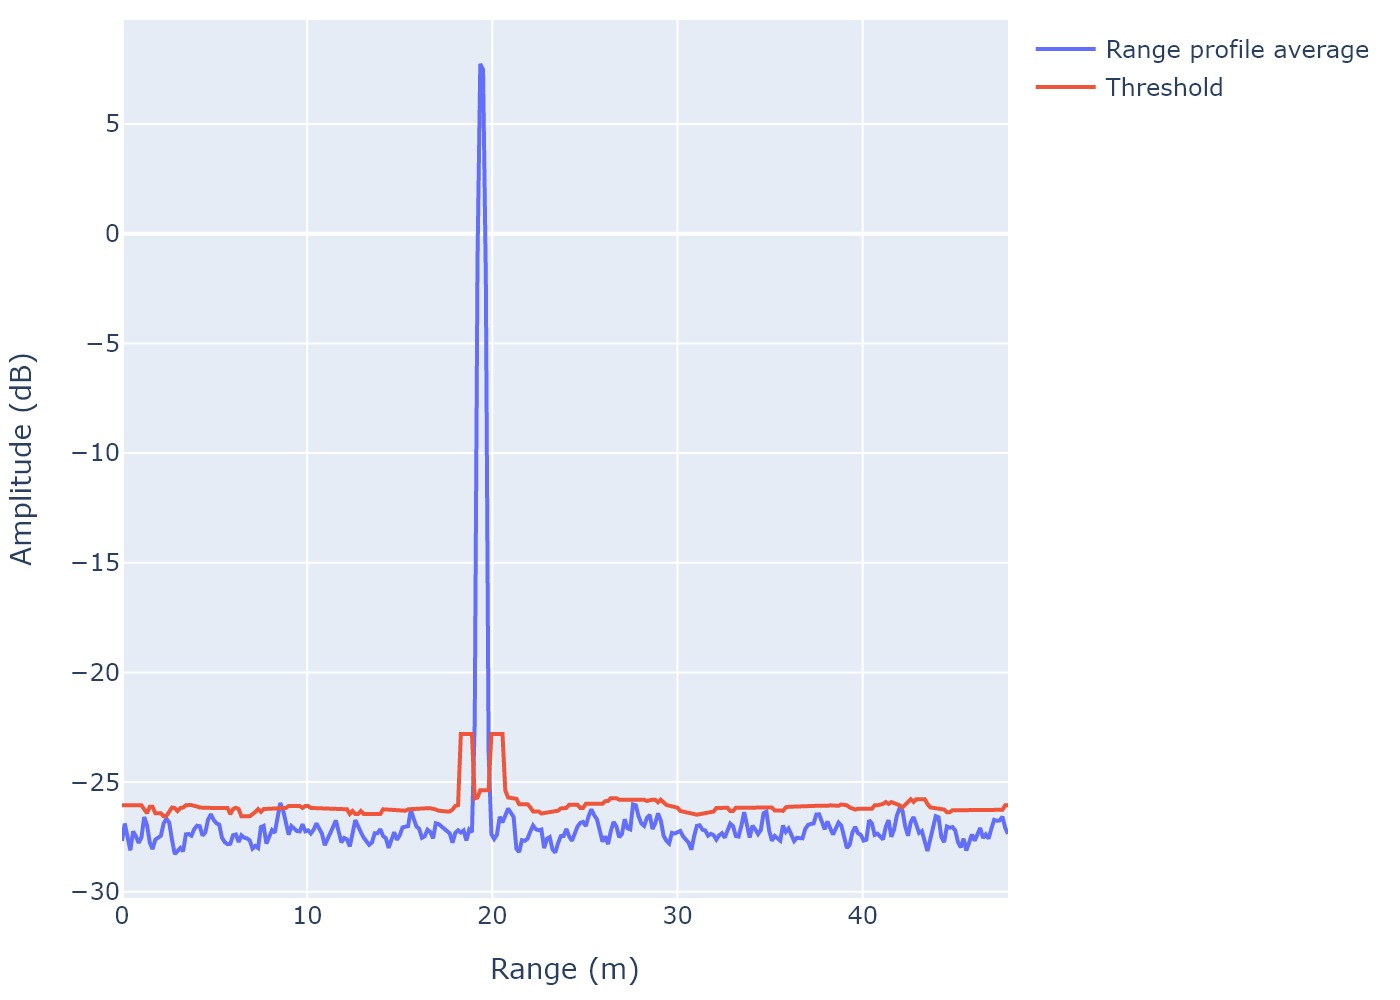

In [ ]:
max_range = (
    3e8
    * radar.radar_prop["receiver"].bb_prop["fs"]
    * radar.radar_prop["transmitter"].waveform_prop["pulse_length"]
    / radar.radar_prop["transmitter"].waveform_prop["bandwidth"]
    / 2
)
range_axis = np.flip(
    np.linspace(0, max_range, radar.sample_prop["samples_per_pulse"], endpoint=False)
)

fig = go.Figure()

fig.add_trace(
    go.Scatter(
        x=range_axis,
        y=20 * np.log10(range_profile_avg[0, :]),
        name="Range profile average",
    )
)
fig.add_trace(go.Scatter(x=range_axis, y=20 * np.log10(cfar), name="Threshold"))

fig.update_layout(
    yaxis=dict(title="Amplitude (dB)"),
    xaxis=dict(title="Range (m)"),
    margin=dict(l=10, r=10, b=10, t=10),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))

### Angle Processing

Use anglular FFT to obtain the image.


In [ ]:
from scipy import fft
from scipy import signal

win_el = signal.windows.chebwin(64, at=50)
win_az = signal.windows.chebwin(128, at=50)

win_mat = np.tile(win_el[..., np.newaxis], (1, N_rx)) * np.tile(
    win_az[np.newaxis, ...], (N_tx, 1)
)

det_idx = np.where(range_profile_avg > cfar)[1]

spec = np.zeros((1024, 1024))
for peak_idx in range(0, len(det_idx)):
    raw_bv = range_profile[:, 0, det_idx[peak_idx]]

    bv = np.zeros((N_tx, N_rx), dtype=np.complex128)

    half_tx = int(N_tx / 2)
    half_rx = int(N_rx / 2)
    for t_idx in range(0, half_tx):
        bv[t_idx, 0:half_rx] = raw_bv[t_idx * N_rx : (t_idx * N_rx + half_rx)]
        bv[t_idx, half_rx:] = raw_bv[
            int((t_idx + half_tx) * N_rx) : ((t_idx + half_tx) * N_rx + half_rx)
        ]

        bv[t_idx + half_tx, 0:half_rx] = raw_bv[
            (t_idx * N_rx + half_rx) : (t_idx * N_rx + N_rx)
        ]
        bv[t_idx + half_tx, half_rx:] = raw_bv[
            int((t_idx + half_tx) * N_rx + half_rx) : int(
                (t_idx + half_tx) * N_rx + N_rx
            )
        ]
    spec = np.maximum(
        spec, np.abs(fft.fftshift(fft.fft2(bv[:, :] * win_mat, s=[1024, 1024])))
    )

_Plot imaging result_


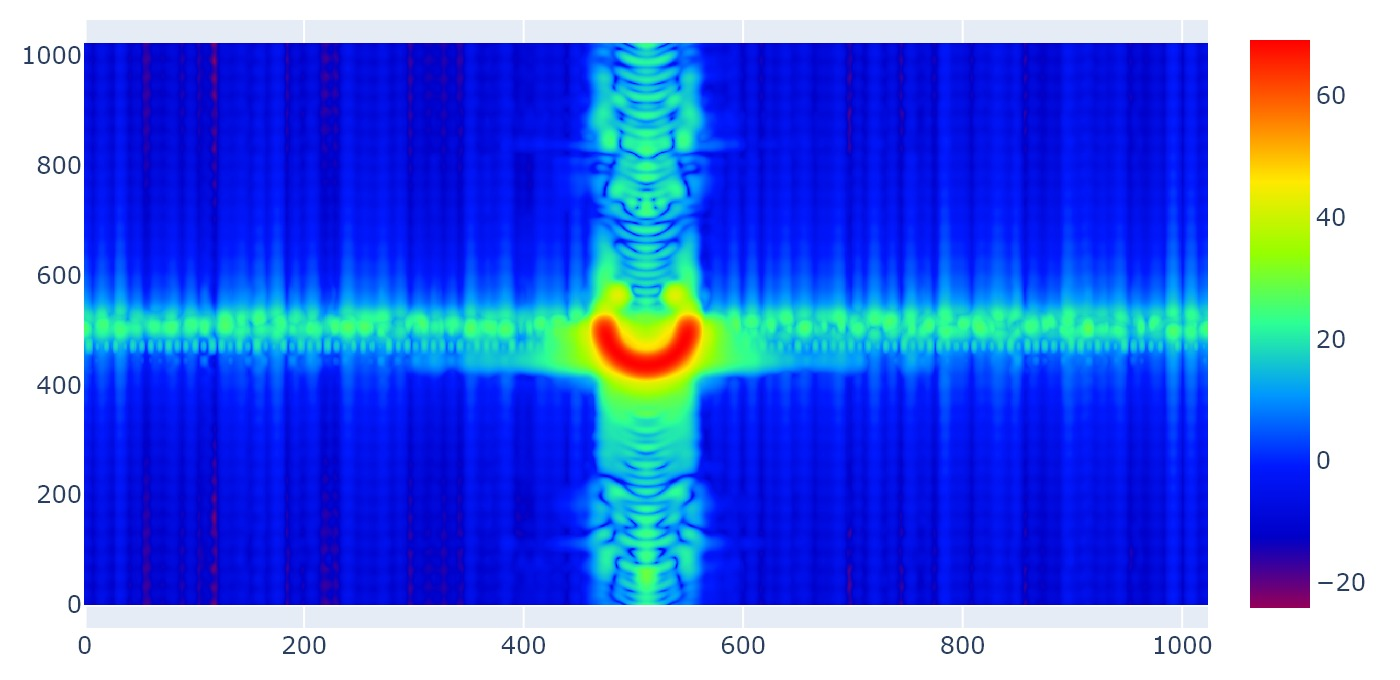

In [ ]:
fig = go.Figure()

fig.add_trace(go.Heatmap(z=20 * np.log10(spec), colorscale="Rainbow"))

fig.update_layout(
    height=340,
    xaxis=dict(),
    yaxis=dict(scaleanchor="x", scaleratio=0.5),
    margin=dict(l=10, r=10, b=10, t=10),
)

# uncomment this to display interactive plot
# fig.show()

# display static image to reduce size on radarsimx.com
img_bytes = fig.to_image(format="jpg", scale=2)
display(Image(img_bytes))